In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import random
import matplotlib.pyplot as plt
import logging
import time

Cargar los datos de test

In [2]:
from LSTM_DDQN_hourly import load_and_preprocess_data

# Cargar datos de test
data_array, df, scaler = load_and_preprocess_data('C:\\Andrey\\Kakua_Projets\\Trading\\Bot_RL_v1\\Datasets\\historical_01-01-2019_to_01-01-2025_ETHUSDT.csv')

# --- División de datos solo datos de test ---
train_size = int(0.8 * len(data_array))
test_data = data_array[train_size:]

print(f"\nDivisión de datos:")
print(f"Total: {len(data_array)}")
print(f"Evaluación: {len(test_data)}")

Usando: cuda

División de datos:
Total: 44687
Evaluación: 8938


Crear agente y cargar modelo entrenado

In [3]:
from LSTM_DDQN_hourly import EnhancedDQNAgent, EnhancedTradingEnvironment

# Configuración inicial
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


window_size = 24
test_env = EnhancedTradingEnvironment(test_data, window_size)
state_size = test_env.state_size
action_size = test_env.action_space
save_path = 'best_trading_model.pth'
# 1. Inicializar agente (como en tu entrenamiento)
agent = EnhancedDQNAgent(state_size, action_size)

# 2. Cargar modelo (la función detecta automáticamente GPU/CPU)
agent, best_score, train_rewards = agent.load_model(save_path, device)

✅ Modelo cargado correctamente en cuda
| ε: 0.0500 | Mejor Score: -0.67% |


In [4]:
from LSTM_DDQN_hourly import evaluate

# --- Evaluación Final (AJUSTE DE MÉTRICAS PARA HORARIO) ---
print("\nEvaluando con datos de test...")
final_return, portfolio_history, price_history, actions_history = evaluate(
    agent, test_env, df, return_full_history=True
)


Evaluando con datos de test...


Metricas

In [5]:
# Cálculo de métricas
final_value = portfolio_history[-1]
returns = np.diff(portfolio_history) / portfolio_history[:-1]
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
max_drawdown = (np.maximum.accumulate(portfolio_history) - portfolio_history).max()
buy_hold_return = (price_history[-1] / price_history[0] - 1) * 100
actions_dist = pd.Series(actions_history).value_counts(normalize=True)
print("\n--- Resultados Finales ---")
print(f"Valor inicial: $10,000.00")
print(f"Valor final: ${final_value:,.2f}")
print(f"Retorno estrategia: {(final_value/10000-1)*100:.2f}%")
print(f"Retorno Buy & Hold: {buy_hold_return:.2f}%")
print(f"Ratio de Sharpe: {sharpe_ratio:.2f}")
print(f"Max Drawdown: ${max_drawdown:,.2f} ({max_drawdown/10000:.2%})")
print(f"Acciones: Comprar={actions_dist.get(2, 0):.1%}, "
        f"Vender={actions_dist.get(0, 0):.1%}, "
        f"Mantener={actions_dist.get(1, 0):.1%}")


--- Resultados Finales ---
Valor inicial: $10,000.00
Valor final: $10,114.42
Retorno estrategia: 1.14%
Retorno Buy & Hold: 53.85%
Ratio de Sharpe: 0.07
Max Drawdown: $214.36 (2.14%)
Acciones: Comprar=1.6%, Vender=96.8%, Mantener=1.5%


Gráficos

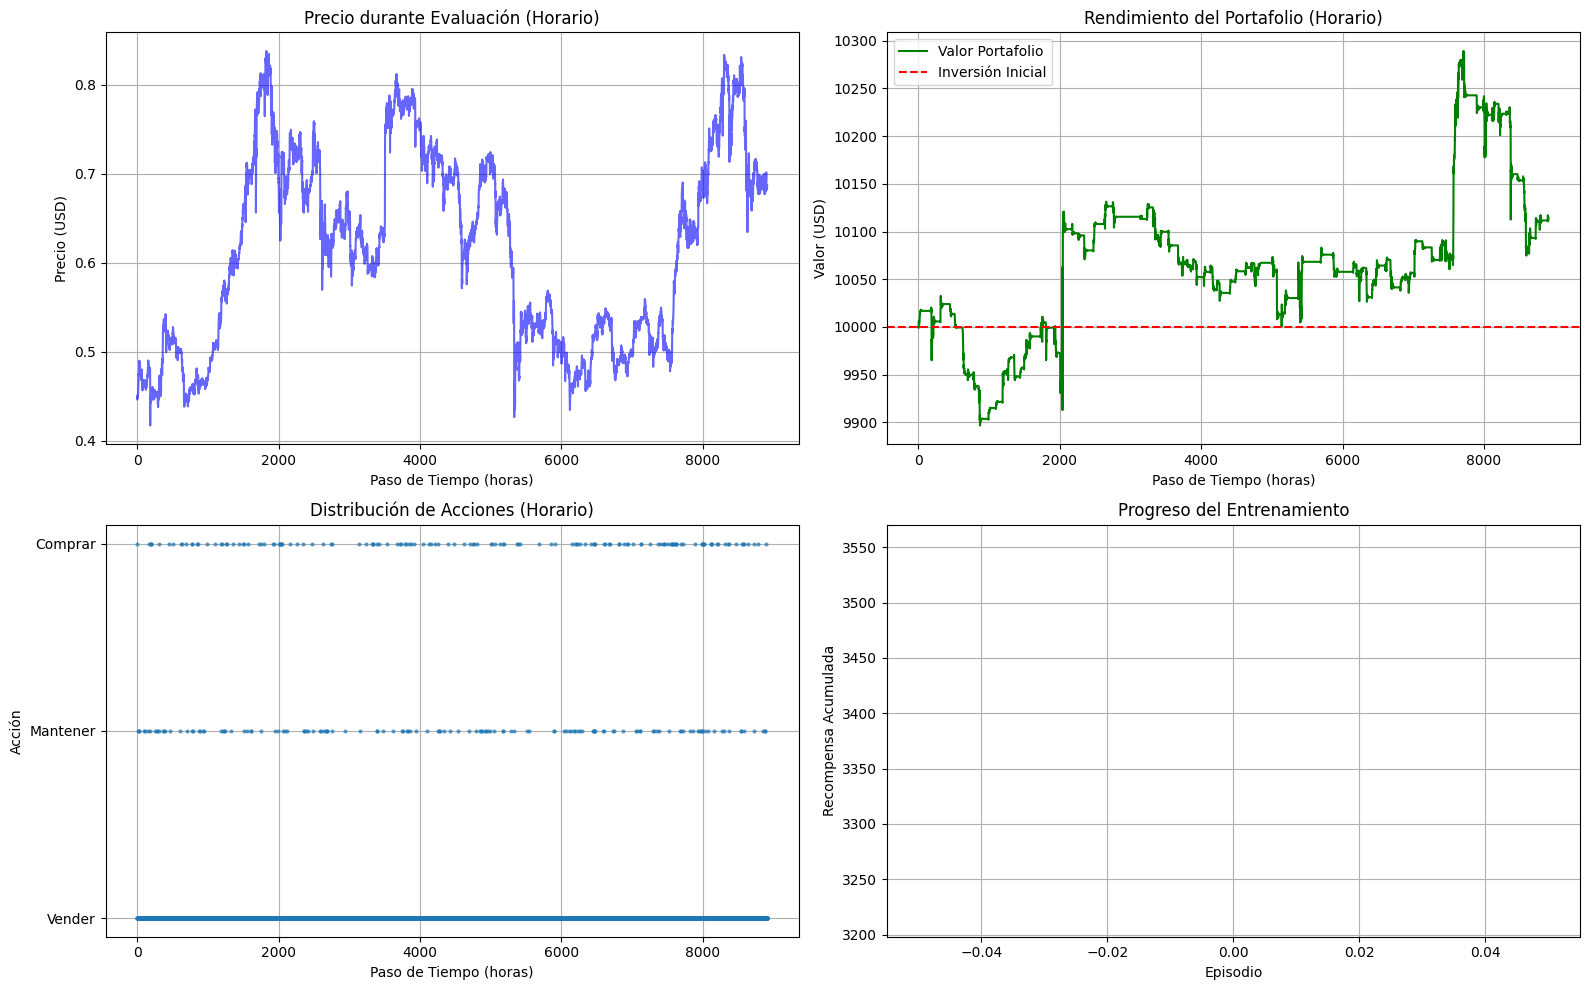

In [6]:
# --- Visualización ---
plt.figure(figsize=(16, 10))

# Gráfico 1: Precio
plt.subplot(2, 2, 1)
plt.plot(price_history, label='Precio ETH', color='blue', alpha=0.6)
plt.xlabel('Paso de Tiempo (horas)')  # Actualizad
plt.ylabel('Precio (USD)')
plt.title('Precio durante Evaluación (Horario)')  # Actualizado
plt.grid(True)

# Gráfico 2: Portafolio
plt.subplot(2, 2, 2)
plt.plot(portfolio_history, label='Valor Portafolio', color='green')
plt.axhline(y=10000, color='red', linestyle='--', label='Inversión Inicial')
plt.xlabel('Paso de Tiempo (horas)')  # Actualizado
plt.ylabel('Valor (USD)')
plt.title('Rendimiento del Portafolio (Horario)')  # Actualizado
plt.legend()
plt.grid(True)

# Gráfico 3: Acciones
plt.subplot(2, 2, 3)
plt.plot(actions_history, 'o', markersize=2, alpha=0.6)
plt.yticks([0, 1, 2], ['Vender', 'Mantener', 'Comprar'])
plt.xlabel('Paso de Tiempo (horas)')  # Actualizado
plt.ylabel('Acción')
plt.title('Distribución de Acciones (Horario)')  # Actualizado
plt.grid(True)

# Gráfico 4: Recompensas
plt.subplot(2, 2, 4)
plt.plot(train_rewards, label='Recompensa', color='purple')
plt.xlabel('Episodio')
plt.ylabel('Recompensa Acumulada')
plt.title('Progreso del Entrenamiento')
plt.grid(True)

plt.tight_layout()
plt.show()